Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib
successully read low_temp_env_baseline5C.csv
0.01


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['flag', 'mod', 'trunc']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


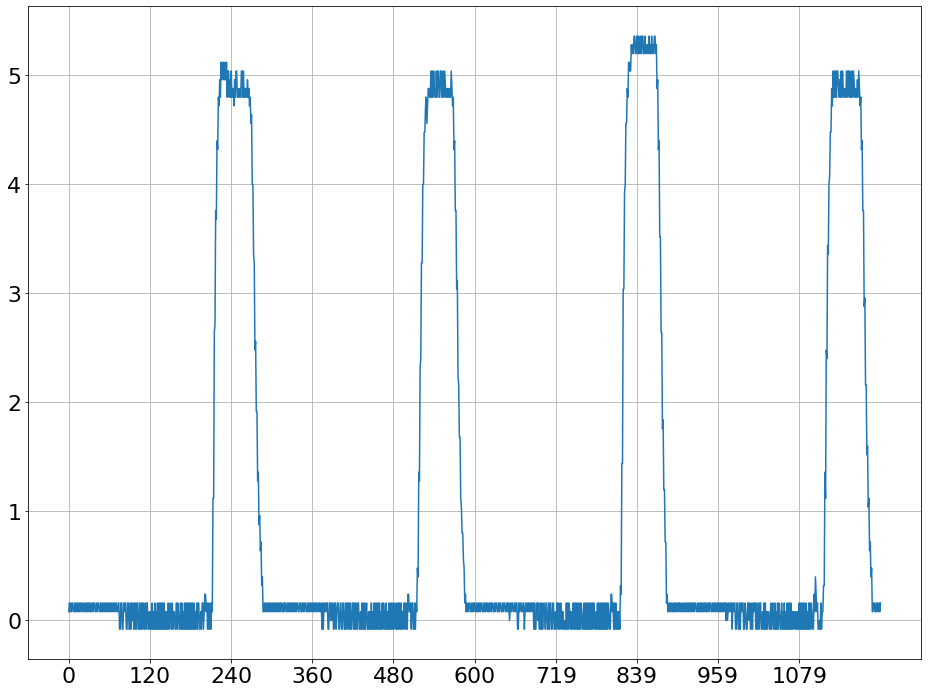

In [60]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
from scipy import signal
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

%pylab
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16,12)
matplotlib.rcParams.update({'font.size': 22})
fig_num = 0

#Parameters for import, naming of figures, and for saving or not saving figures.
name = "low_temp_env_baseline5C" #file name NO EXTENSION
dose_target = 6 #dose target for naming figures
BPM = 20 #effeective breath rate for naming figures 
mod = f"GCC_Test-{name}" #custom modifier for naming figures.
save_fig_dose_analysis = True #true = save; false = don't save

ext = ".csv"
filename = name + ext

#Read the data
try:
    data = pd.read_csv(f"pulses/{filename}")
    print(f"successully read {filename}")
except Exception as E:
    print("Error reading data file")
    print(E)

#Convert/Prep the Data  
#this script is written to handle data captured from Rigol oscilloscope software which is hooked up to the Cambustion on the NO Analysis bench in the lab
#if the format of the imported file changes this section MUST be changed to accomodate.
increment = data.Increment[0]
print(increment)

data = data.drop([0]).reset_index(drop = True)

data = data.rename(columns={"X":"Index","CH1": "Flow", "CH2": "NO","CH3": "NO2"})

data.Index = data.Index.astype(int)

data = data.drop(['Start','Increment'], axis = 1)
data.Flow = data.Flow.astype(float)
data.NO = data.NO.astype(float)
data.NO2 = data.NO2.astype(float)

fig_num += 1
figure(fig_num)
plot(data.Index, data.NO)
xticks(np.arange(0,max(data.Index),step = max(data.Index)/10))
grid(True)

In [61]:
print(len(data.Index))

check = input("Do you need to clip the data [y/n]?")

if check == 'y':
    front_clip = int(input("Provide index of front of data clip"))
    end_clip = int(input("Provide index of end of data clip"))
    
    if end_clip == -1:
        end_clip = len(data.Index)

    front_clip_list = np.arange(0,front_clip)
    end_clip_list = np.arange(end_clip,max(data.Index)+1)
    clip_list = np.append(front_clip_list, end_clip_list)

    data_temp = data.drop(clip_list).reset_index(drop = True)
    data_temp.Index = data_temp.Index - front_clip
#     print(data_temp)

    fig_num += 1
    figure(fig_num)
    plot(data_temp.Index, data_temp.NO)
    
    data = data_temp

1200


Do you need to clip the data [y/n]? n


In [62]:
#Data comes in volts. Volt signals are converted to physical signals using appropriate conversions. Change the constants for the NO slope and offset as needed.

data['Time'] = data.Index * increment
#converstion from volts
NO_slope = 99.75 #ppm/volt
NO_offset = 0.12 #volt
NO2_slope = 10.38 #ppm/volt
NO2_offset = 0.016 #volt

data['VolumeFlow'] = (data.Flow - 1) * 2.5

data['NO_volt'] = data.NO
data['NO'] = (data.NO_volt - NO_offset)*NO_slope

data['NO2_volt'] = data.NO2
data['NO2'] = (data.NO2_volt - NO2_offset)*NO2_slope
print(data)
print(data.Time)

      Index  Flow    NO      NO2   Time  VolumeFlow  NO_volt  NO2_volt
0         0  0.96 -3.99  0.24912   0.00        -0.1     0.08     0.040
1         1  1.08  3.99  0.00000   0.01         0.2     0.16     0.016
2         2  0.96 -3.99  0.00000   0.02        -0.1     0.08     0.016
3         3  1.04  3.99  0.16608   0.03         0.1     0.16     0.032
4         4  0.96 -3.99 -0.16608   0.04        -0.1     0.08     0.000
...     ...   ...   ...      ...    ...         ...      ...       ...
1195   1195  1.08  3.99  0.16608  11.95         0.2     0.16     0.032
1196   1196  0.96 -3.99  0.24912  11.96        -0.1     0.08     0.040
1197   1197  1.04  3.99  0.00000  11.97         0.1     0.16     0.016
1198   1198  0.96 -3.99 -0.16608  11.98        -0.1     0.08     0.000
1199   1199  1.08  3.99  0.24912  11.99         0.2     0.16     0.040

[1200 rows x 8 columns]
0        0.00
1        0.01
2        0.02
3        0.03
4        0.04
        ...  
1195    11.95
1196    11.96
1197    11.

In [63]:
#Custom function for plotting the various edges and indications that are part of the Dose Analysis.

def plot_all(NO_start,Pulse_start,NO_stop,Pulse_stop,Flow_start,Priming):
    if NO_start == True:
        for edges in start_edge_time_NO:
            if trunc == False:
                axvline(x = edges, color = 'red')
            elif (trunc == True) & (edges < data.Time.iloc[stop]):
                axvline(x = edges, color = 'red')
    if Pulse_start == True:
        for edges in pulse_start_time_NO:
            if trunc == False:
                axvline(x = edges, color = 'orange')
            elif (trunc == True) & (edges < data.Time.iloc[stop]):
                axvline(x = edges, color = 'orange')
    if NO_stop == True:
        for edges in stop_edge_time_NO:
            if trunc == False:
                axvline(x = edges, color = 'blue')
            elif (trunc == True) & (edges < data.Time.iloc[stop]):
                axvline(x = edges, color = 'blue')
    if Pulse_stop == True:
        for edges in pulse_stop_time_NO:
            if trunc == False:
                axvline(x = edges, color = 'purple')
            elif (trunc == True) & (edges < data.Time.iloc[stop]):
                axvline(x = edges, color = 'purple')
    if Flow_start == True:
        for edges in start_edge_time_Flow:
            if trunc == False:
                axvline(x = edges, color = 'yellow')
            elif (trunc == True) & (edges < data.Time.iloc[stop]):
                axvline(x = edges, color = 'yellow')
    if Priming == True: 
        for edges in priming_time:
            if trunc == False:
                axvline(x = edges, color = 'gray')
            elif (trunc == True) & (edges < data.Time.iloc[stop]):
                axvline(x = edges, color = 'gray')
                
#This is the Streaming Edge Detection that finds edges. See reference information for more on how this works.

from pandas import Series
from pandas import Timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy import stats 
%matplotlib inline

## https://notebook.community/KKTT/time-series-python-exp/edge-detection/streaming_edge_detection
## https://github.com/KKTT/time-series-python-exp
## https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.97.9527&rep=rep1&type=pdf

def streaming_edge_detection(x, sigma=2.0, threshold=3.0, visualize=False, additional_title=""):
    '''
    streaming edge detection algorithm on signal x
    @param x: original time series
    @param sigma: sigma of Guassian smooth filter, default=2.0
    @param threshold: threshold for edge detection. dx > ma * thresohld, default=3.0
    @return list of edge tuples [(sign, position)], e.g. [("+", 20), ("-", 30)]
    '''
    alpha = 0.05
    width = int(3*sigma)
    edges = []
    min_dist = 20 # min distance of two edges of the same sign
    
    gaussian = signal.gaussian(width*2+1, sigma)
    d1_gaussian = signal.convolve(gaussian, [-1, 0 , 1], mode='same')
    ma = 0
    edge_pos = []
    edge_positive= []
    edge_negative = []
    edge_val = []
    last_positive = -1
    last_negative = -1
    last_sign = 0
    
    derivative = np.zeros(len(x))
    dx_buffer = np.zeros(3)
    low_buffer = np.zeros(len(x))
    high_buffer = np.zeros(len(x))
    s = 0
    
  
    # convolve signal x with d1_guassian window
    for n in range(width, len(x)-width):
        dx = 0
        if sigma > 0:
            # convolve sum first half
            for k in range(1, width+1):
                dx += d1_gaussian[width-k] * x[n-k] if n >= k else 0 
            # middle point
            dx += x[n] * d1_gaussian[width]
            # convolve sum second half
            for k in range(1, width+1):
                dx += d1_gaussian[width+k] * x[n+k] if n+k < len(x) else 0
        else:
            # no smoothing at all
            dx = x[n] - x[n-1] if n > 0 else 0
            
        derivative[n] = dx
        # buffer shift
        dx_buffer[0] = dx_buffer[1]
        dx_buffer[1] = dx_buffer[2]
        dx_buffer[2] = dx
        
        low_quantile = 0 if n==0 else np.percentile(np.abs(derivative[:n]), 50)
        high_quantile = 0 if n==0 else np.percentile(np.abs(derivative[:n]), 95)
        low_buffer[n] = low_quantile
        high_buffer[n] = high_quantile
        ratio = 0 if low_quantile == 0 else high_quantile / low_quantile


        #s += abs(dx)
        #ma = s / (n-width+1)
        #ma_buffer[n] = ma
       
   
        if dx_buffer[1] > low_quantile * threshold:
            # find local max
            if dx_buffer[1] >= dx_buffer[2] and dx_buffer[1] >= dx_buffer[0]:
                if n-1 - last_positive > min_dist and last_sign <= 0:
                    edges.append(("+", n-1))
                    edge_pos.append(n-1)
                    edge_positive.append(n-1)
                    edge_val.append(dx_buffer[1])
                    last_positive = n-1
                    last_sign = +1
        elif dx_buffer[1] < -low_quantile * threshold:
            # find local min
            if dx_buffer[1] <= dx_buffer[2] and dx_buffer[1] <= dx_buffer[0]:
                if n-1 - last_negative > min_dist and last_sign >= 0:
                    edges.append(("-", n-1))
                    edge_pos.append(n-1)
                    edge_negative.append(n-1)
                    edge_val.append(dx_buffer[1])
                    last_negative = n-1
                    last_sign = -1

    if visualize:
        num_figure = 3
#         plt.style.use('seaborn-paper')
        fig = plt.figure(figsize=(18,15))
        ax1 = fig.add_subplot(num_figure,1,1)
        ax1.plot(x)
        ax1.set_title("Original signal: {}".format(additional_title))
        ax2 = fig.add_subplot(num_figure,1,2)
        ax2.plot(derivative)
        ax2.plot(np.zeros(len(x)))
        ax2.plot(edge_pos, edge_val,"o", label="detected edge positions")
        #ax2.legend(loc="lower left")
        ax2.set_title("Gaussian derivative signal and edge detector results")
        ax3 = fig.add_subplot(num_figure,1,3)
        ax3.plot(low_buffer, label="50th percentile")
        ax3.plot(high_buffer, label="95th percentile")
        ax3.legend(loc="lower right", fontsize=16)
        ax3.set_title("quantile analysis")
    return edges, ratio, edge_positive, edge_negative

In [64]:
# This cell contains Data manipulations for correcting issues that hinder edge detection in the Dose Analysis cell (RUN AS NEEDED)

# b, a = signal.butter(4, 0.250)
# NO_temp = signal.filtfilt(b, a, data.NO)

# data['NO'] = NO_temp

# NO_temp = np.where(data.NO < 20, 0 ,data.NO)
# plot(NO_temp)

# data.NO = NO_temp

median pulse concentration: 474.81
mean pulse concentration: 479.9
mean pulse volume: 8.64
breath rate: 19.74
mean NO mass per pulse 0.005118
NO Dose: 6.06 mg/hr
mean NO2 mass per pulse 4.7e-05
NO2 Dose: 55.15806346958618 ug/hr
Pulse Duration 0.5600000000000005

479.9
8.64
19.74
0.005118
6.06
4.7e-05
55.16


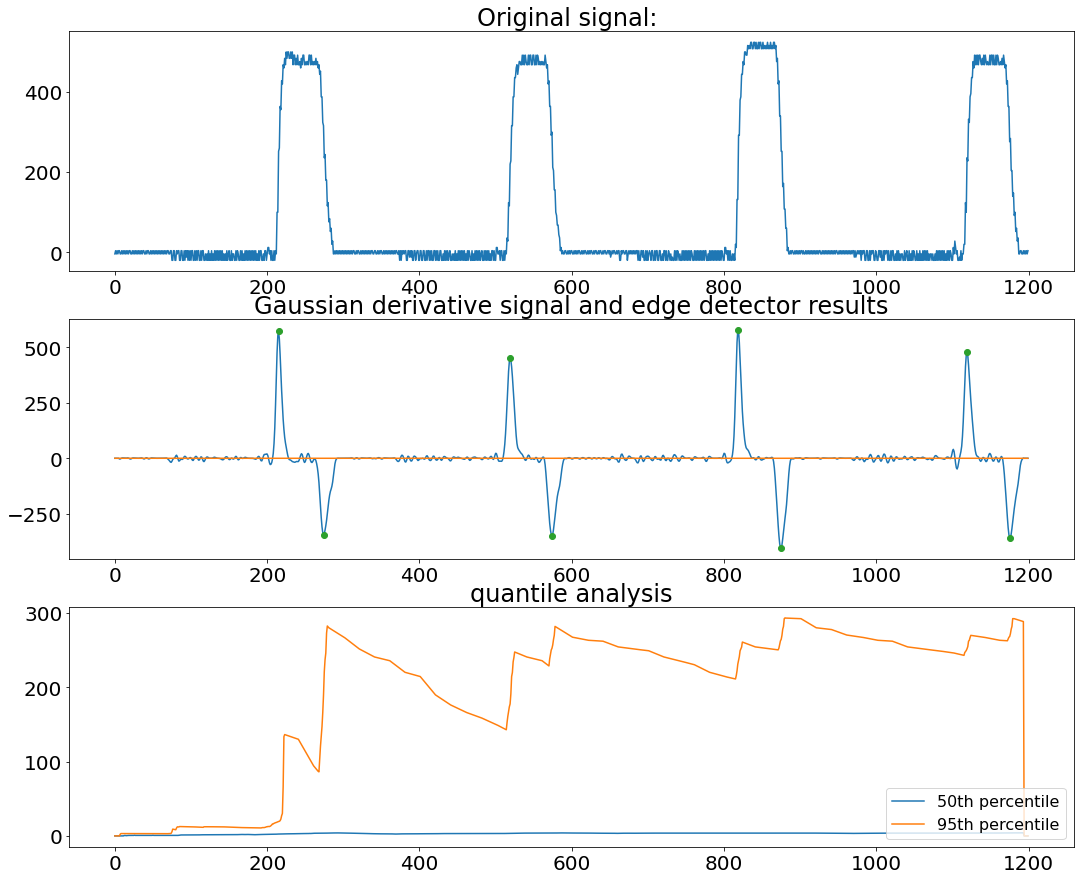

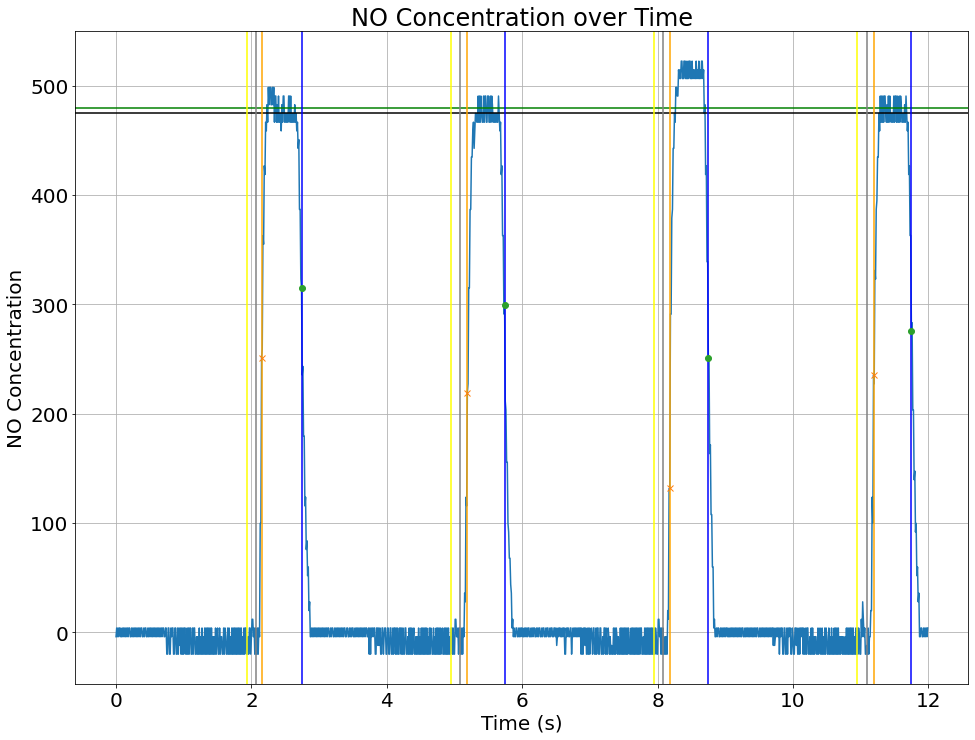

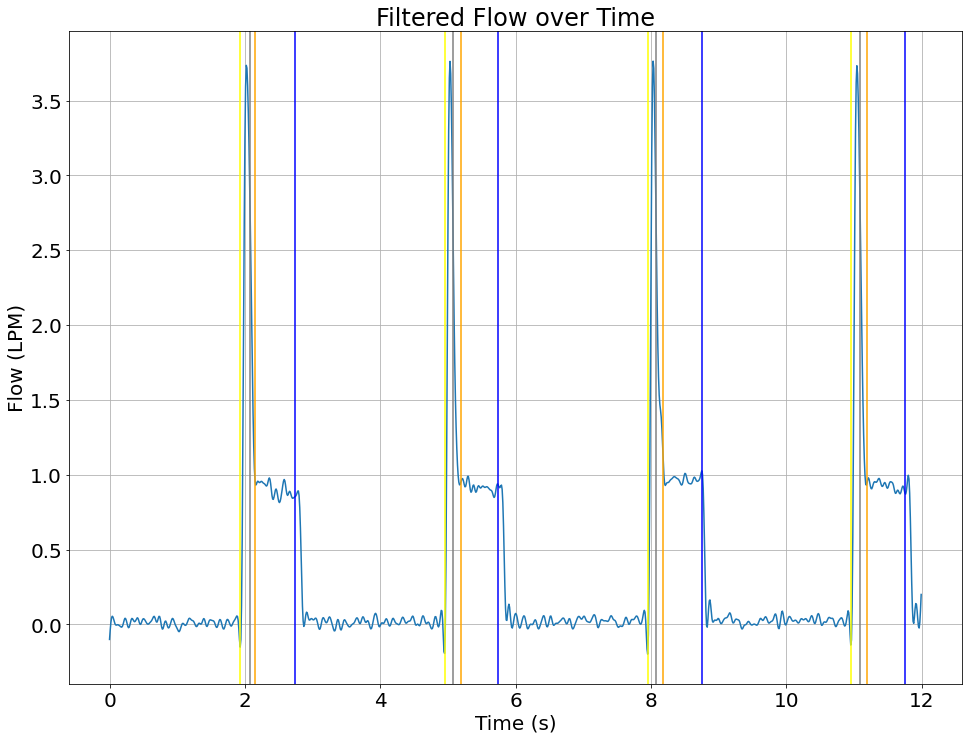

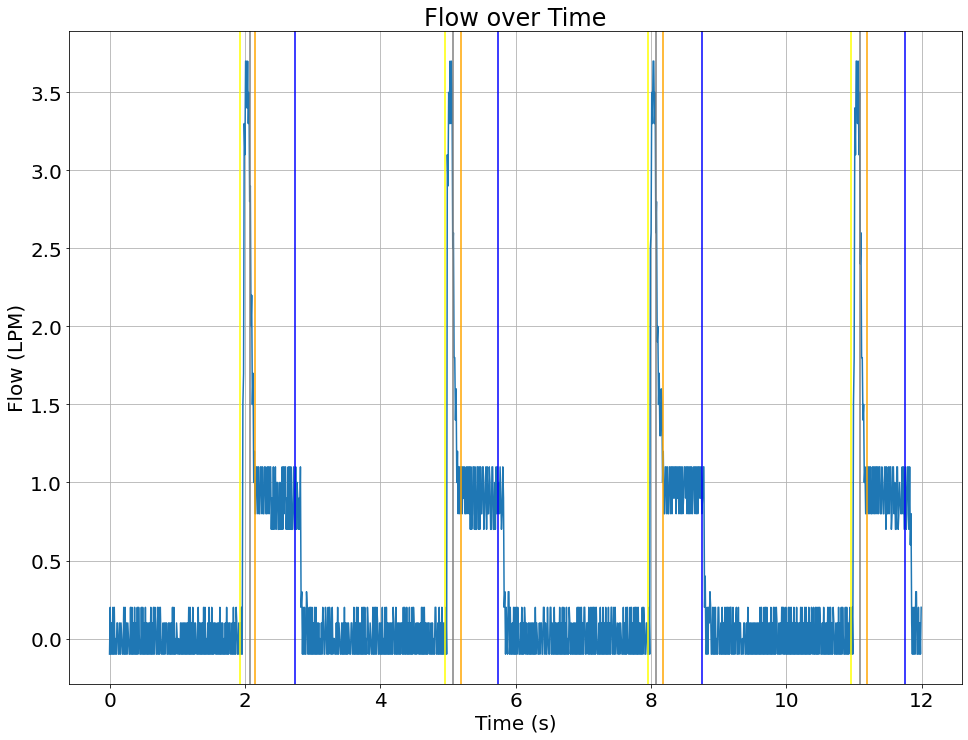

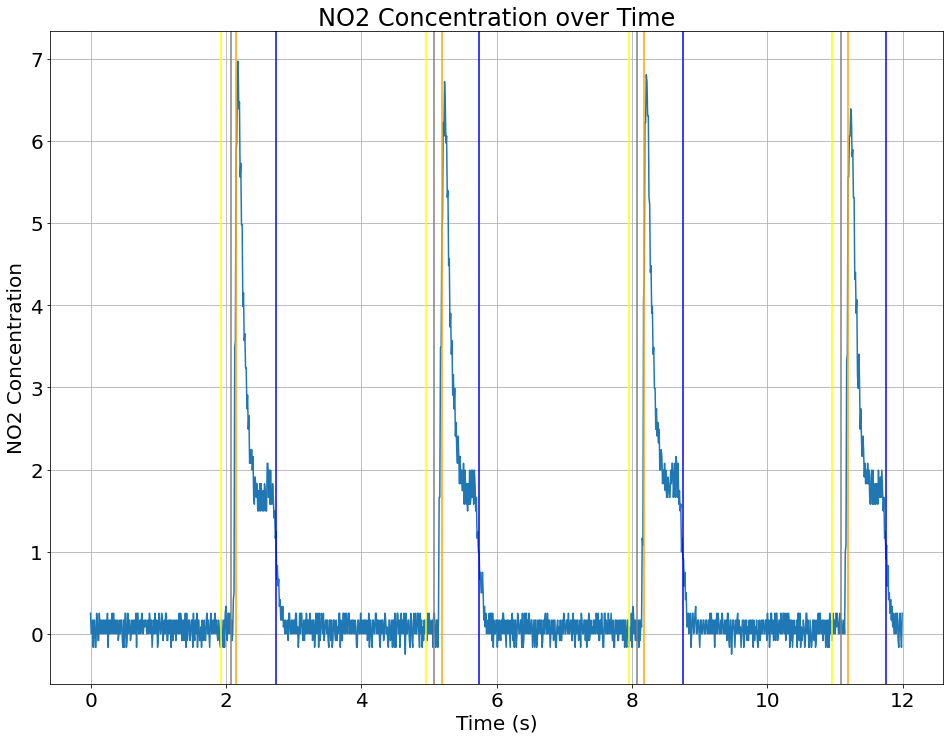

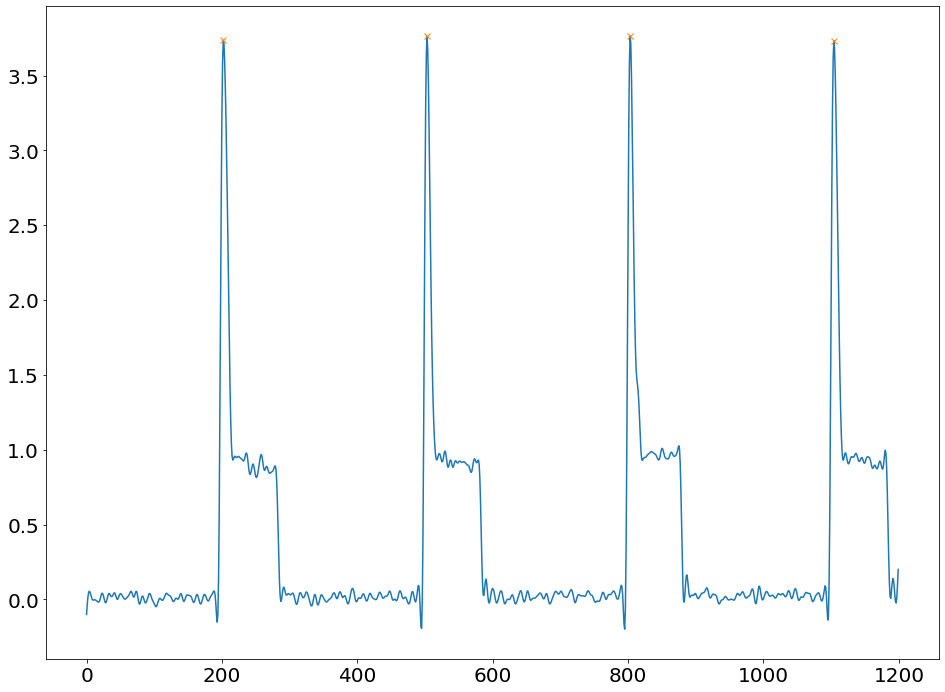

In [66]:
##Dose Analysis Body

matplotlib.rcParams['figure.figsize'] = (16,12)
matplotlib.rcParams.update({'font.size': 20})

trunc = False
start = 0
stop = 400
# print(data)

#parameters 
Temp_ambient = 20.0 #[degC] get from config
Pressure_ambient = 1.0 # [atm] get from config

c2k = 273.15 #Add this to the temperature to convert from degrees Celsius to degrees Kelvin.
atm2pa = 101325 #[Pa/atm] Multiply by this to convert from Atmospheres to Pascals. Divide to convert the other way.
ft2m = 0.3048 #[m/ft] Multiply by this to convert from feet to meters. Divide to convert the other way.
min2sec = hr2min = 60 #[s/min] Multiply by this to convert from minutes to seconds. Divide to convert the other way.
psi2Pa = 6894.76 #[pa/psi] Multiply by this to convert from psi to pa. Divide to convert the other way.
psi2atm = 0.068046 #[atm/psi] Multiply by this to convert from psi to atm. Divide to convert the other way.

gas_constant = 8.314462618 # [m^3*Pa/K*mol]
molar_mass_NO = 30.01 #[g/mol]
molar_mass_NO2 = 46.0055 #[g/mol]
molar_mass_air = 28.9645 #[g/mol]

molar_density = ((Pressure_ambient*atm2pa)/(gas_constant*(c2k + Temp_ambient)))/1000 # [mol/L]
#This calculates the molar density of a gas using the ideal gas law. It is used to convert from volume of NO to dosage.

#Device characteristics
priming_volume = 4.3 / 1000 #L

#1 top of waveforms detection
lower_bound_NO = max(data.NO*.8)
concentration_top = data.NO.loc[np.where(np.array(data.NO) > lower_bound_NO, True,False)]
# print(concentration_top)
median_concentration_pulse = np.median(concentration_top)

#NO pulse start and stop determined by edge detection. The third argument of the streaming_edge_detection function needs to be tuned
#such that there are the appropriate number of rising and falling edges. A future version of this code will iterate this method until the correct number
#of edges are found by looping over the third argument.
gt_edges, _ , NO_pos, NO_neg = streaming_edge_detection(data.NO, 2, 30, True)
# print(gt_edges)
positives = data['Time'].iloc[NO_pos]
negatives = data['Time'].iloc[NO_neg]

pulse_start_index_NO = NO_pos
stop_edge_index_NO = NO_neg
pulse_start_time_NO = data.Time.iloc[NO_pos]
stop_edge_time_NO = data.Time.iloc[NO_neg]

##############
#The following two methods (T90 rising and T05 falling) are unused in the remaining computations of the script. They are included as plot-able using the plot_all function so I have left them here.
#T90 detection on the rising side - abs threshold start of pulse detection
flag = False
start_threshold_abs_NO = np.median(concentration_top)*.9
start_edge_time_NO = []
start_edge_time_NO_temp = 0
start_edge_index_NO = []

time_reset = 0.5
for i in np.arange(0,len(data.NO)):
    if i <= len(data.NO)-3:
        if (data.NO[i] > start_threshold_abs_NO) and (flag == False):
            start_edge_time_NO.append(data.Time[i])
            start_edge_time_NO_temp = data.Time[i]
            start_edge_index_NO.append(i)
            flag = True
        elif (data.Time[i] - start_edge_time_NO_temp > time_reset) and (flag == True):
            flag = False
            
#T05 detection on the falling side - abs threshold end of pulse detection           
pulse_stop_threshold_abs_NO = np.median(concentration_top)*.05
pulse_stop_time_NO = []
pulse_stop_index_NO = []

for starts in start_edge_index_NO:
    flag = False
    for i in np.arange(starts, len(data.NO)-2):
        if (data.NO[i+2]<=pulse_stop_threshold_abs_NO) and flag == False:
            pulse_stop_time_NO.append(data.Time[i])
            pulse_stop_index_NO.append(i)
            flag = True
###############

#Determine where priming has started
#using a presently static threshold the start of the priming of the cannula is detected. In order to reduce the impact of noise a filtered signal is used. 
start_threshold_abs_Flow = 0.2
start_edge_time_Flow = []
start_edge_index_Flow = []
b, a = signal.butter(4, 0.250)
flow_temp = signal.filtfilt(b, a, data.VolumeFlow)
data['flow_temp'] = flow_temp
start_edge_time_Flow_temp = 0

back = 30
valleys = []
peaks, _ = find_peaks(data.flow_temp, height=max(data.flow_temp)*0.7, distance = 200)
for i in peaks:
    valley = np.where(data["flow_temp"].iloc[np.arange(i-back,i)] == min(data["flow_temp"].iloc[np.arange(i-back,i)]))
    valleys = valleys + (list(valley[0]))
#     print(data["flow_temp"].iloc[np.arange(i-back,i)])
#     print(valleys)    
    start_edge_index_Flow.append(int(i - (back - valley[0])))
    start_edge_time_Flow.append(data.Time[int(i - (back - valley[0]))])
#     print(start_edge_index_Flow)
# print("local max", data.flow_temp[argrelextrema(data.flow_temp, np.greater)[0]])
        
#determine where priming has ended
priming_index = []
priming_time = []
for j in np.arange(len(start_edge_index_Flow)):
    i = start_edge_index_Flow[j]
    volume_temp = 0
    cnt = 1
    if j < len(start_edge_index_Flow)-1:
        if i+cnt < start_edge_index_Flow[j+1]:
            while volume_temp <= priming_volume:
                if (i+cnt) < len(data.VolumeFlow):
                    h = (data.Time[i+cnt] - data.Time[i+cnt-1]) 
                    b = ((data.VolumeFlow[i+cnt] + data.VolumeFlow[i+cnt-1])/2)/60
                    volume_temp = volume_temp + h * b
                    cnt += 1
            priming_index.append(i+cnt)
            priming_time.append(data.Time[i+cnt])
    elif j == len(start_edge_index_Flow)-1:
        if i+cnt < len(data.VolumeFlow):
            while volume_temp <= priming_volume:
                if (i+cnt) < len(data.VolumeFlow):
                    h = (data.Time[i+cnt] - data.Time[i+cnt-1]) 
                    b = ((data.VolumeFlow[i+cnt] + data.VolumeFlow[i+cnt-1])/2)/60
                    volume_temp = volume_temp + h * b
                    cnt += 1
            priming_index.append(i+cnt)
            priming_time.append(data.Time[i+cnt])
            
output = { "pulse_volume":[], "volume_NO":[], "volume_NO2":[], "mass_NO":[],"mass_NO2":[],'pulse_duration':[]}

error = False
if len(pulse_start_index_NO) == len(stop_edge_index_NO):
    for i in np.arange(0,len(pulse_start_index_NO)):
        pulse_volume = 0
        pulse_volume_NO = 0
        pulse_volume_NO2 = 0
        pulse_mass_NO = 0
        pulse_mass_NO2 = 0
        pulse_duration = 0
#         print(start_edge_time_NO[i])

        if pulse_start_index_NO[i] < priming_index[i]:
            start2 = priming_index[i]
        else:
            start2 = pulse_start_index_NO[i]
        for j in np.arange(start2, stop_edge_index_NO[i]-1):
#             print(j)
            h = (data.Time[j+1] - data.Time[j]) 
            b = ((data.VolumeFlow[j+1] + data.VolumeFlow[j])/2)/60
            volume = h * b
            pulse_volume = pulse_volume + volume
#             print(h)

            #5 convert to mg
            volume_NO = volume * (median_concentration_pulse * (1/1000000)) #[L] * [uL/L] * [L/uL] = [L]
            pulse_volume_NO = pulse_volume_NO + volume_NO
            mass_NO = volume_NO * molar_density * molar_mass_NO * 1000 #[L] * [mol/L] * [g/mol] * [mg/g] = [mg]
            pulse_mass_NO = pulse_mass_NO + mass_NO
            volume_NO2 = volume * (data.NO2[j+1] + data.NO2[j])/2 * (1/1000000) #[L] * [uL/L] * [L/uL] = [L]
            pulse_volume_NO2 = pulse_volume_NO2 + volume_NO2
            mass_NO2 = volume_NO2 * molar_density * molar_mass_NO2 * 1000 #[L] * [mol/L] * [g/mol] * [mg/g] = [mg]
            pulse_mass_NO2 = pulse_mass_NO2 + mass_NO2
            
            pulse_duration = data.Time[stop_edge_index_NO[i]] - data.Time[start2]
        output['pulse_volume'].append(1000*pulse_volume)
        output['volume_NO'].append(pulse_volume_NO)
        output['volume_NO2'].append(pulse_volume_NO2)
        output['mass_NO'].append(pulse_mass_NO)
        output['mass_NO2'].append(pulse_mass_NO2)
        output['pulse_duration'].append(pulse_duration)
else:
    print('Error unequal starts and ends')
    error = True
        
# print(output)
print('median pulse concentration:',median_concentration_pulse)
print('mean pulse concentration:',round(np.mean(concentration_top),2))

if (len(start_edge_time_NO) > 1) and error == False:
    mean_pulse_volume = np.mean(output['pulse_volume'])
    print('mean pulse volume:', round(mean_pulse_volume,3))
    
    breath_rate = 60 / (list(pulse_start_time_NO)[1] - list(pulse_start_time_NO)[0])
    print('breath rate:', round(breath_rate,2))
    
    mean_NO_mass = np.mean(output['mass_NO'])
#     include = slice(1,2)
#     mean_NO_mass = np.mean(output['mass_NO'][include])
    print('mean NO mass per pulse',round(mean_NO_mass,6))
    
    NO_dose = mean_NO_mass * breath_rate * 60 # mg * breaths/min * min/hour = mg/hr
    print('NO Dose:', round(NO_dose,2), 'mg/hr')
    
    mean_NO2_mass = np.mean(output['mass_NO2'])
    print('mean NO2 mass per pulse',round(mean_NO2_mass,6))
    
    NO2_dose = mean_NO2_mass * breath_rate * 60 # mg * breaths/min * min/hour = mg/hr
    print('NO2 Dose:',NO2_dose*1000,'ug/hr')
    
    print("Pulse Duration", np.mean(pulse_duration))
    print()
    print(round(np.mean(concentration_top),2))
    print(round(mean_pulse_volume,3))
    print(round(breath_rate,2))
    print(round(mean_NO_mass,6))
    print(round(NO_dose,2))
    print(round(mean_NO2_mass,6))
    print(round(NO2_dose*1000,2))
else:
    print(print('Error unequal starts and ends'))
            
fig_num += 1
figure(fig_num)
if trunc == True:
    plot(data.Time.iloc[start:stop],data.NO.iloc[start:stop])
else:
    plot(data.Time,data.NO)
axhline(y = np.median(concentration_top), color = 'black')
axhline(y = np.mean(concentration_top), color = 'green')
plot_all(False, True, True, False, True, True)
plot(positives, data['NO'].iloc[NO_pos], "x")
plot(negatives, data['NO'].iloc[NO_neg], "o")
grid(True)
xlabel('Time (s)')
ylabel('NO Concentration')
title('NO Concentration over Time')
if save_fig_dose_analysis == True:
    savefig(f"NO Concentration_{dose_target}_mghr_{BPM}_BPM_{mod}")

fig_num += 1
figure(fig_num)
if trunc == True:
    plot(data.Time.iloc[start:stop],data.flow_temp.iloc[start:stop])
else:
    plot(data.Time,data.flow_temp)
grid(True)
plot_all(False, True, True, False, True, True)
grid(True)
xlabel('Time (s)')
ylabel('Flow (LPM)')
title('Filtered Flow over Time')

fig_num += 1
figure(fig_num)
if trunc == True:
    plot(data.Time.iloc[start:stop],data.VolumeFlow.iloc[start:stop])
else:
    plot(data.Time,data.VolumeFlow)
grid(True)
plot_all(False, True, True, False, True, True)
grid(True)
xlabel('Time (s)')
ylabel('Flow (LPM)')
title('Flow over Time')
if save_fig_dose_analysis == True:
    savefig(f"Pulse Flow_{dose_target}_mghr_{BPM}_BPM_{mod}")

fig_num += 1
figure(fig_num)
if trunc == True:
    plot(data.Time.iloc[start:stop],data.NO2.iloc[start:stop])
else:
    plot(data.Time,data.NO2)
grid(True)
plot_all(False, True, True, False, True, True)
grid(True)
xlabel('Time (s)')
ylabel('NO2 Concentration')
title('NO2 Concentration over Time')
if save_fig_dose_analysis == True:
    savefig(f"NO2 Concentration_{dose_target}_mghr_{BPM}_BPM_{mod}")

fig_num += 1
figure(fig_num)
plt.plot(data.flow_temp)
plt.plot(peaks, data.flow_temp[peaks], "x")

# fig_num += 1
# figure(fig_num)
# plot(data.Time,data.NO)

In [49]:
# Calculates the volume delivered between when the priming is determined to have ended and when the NO is detected. 
# This constitutes the added volume in the setup between the end of the cannula and the point of detection in the sensor system.
# The time calculated here is time delay between NO ejection and sensing.

# print(priming_time)
# print(list(pulse_start_time_NO))

print(pulse_start_time_NO - np.array(priming_time))
print(np.mean(pulse_start_time_NO - np.array(priming_time)), 'Mean time delay between priming and NO pulse')

volume_added = []
for i in np.arange(0,len(priming_index)):
    volume_temp = 0
    for j in np.arange(priming_index[i],pulse_start_index_NO[i]-1):
        h = (data.Time[j+1] - data.Time[j]) 
        b = ((data.VolumeFlow[j+1] + data.VolumeFlow[j])/2)/60
        volume_temp = volume_temp + h * b
    volume_added.append(volume_temp)
    
print(volume_added, "L")
print(1000*np.array(volume_added), "mL")

47     0.14
343    0.10
647    0.13
Name: Time, dtype: float64
0.12333333333333334 Mean time delay between priming and NO pulse
[0.0022749999999999992, 0.002124999999999993, 0.0022666666666666764] L
[2.275      2.125      2.26666667] mL
